In [1]:
import pandas as pd # conda install pandas
import numpy as np
import matplotlib.pyplot as plt # conda install matplotlib
from matplotlib.gridspec import GridSpec
import seaborn as sns # conda install seaborn
# conda update -c conda-forge seaborn
from sklearn.model_selection import train_test_split # conda install scikit-learn
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.decomposition import PCA

# Carga de datos y vista general

In [2]:
df = pd.read_csv("data-2024-06-16 1.csv")

In [3]:
df.head()

,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,...,latitude,longitude,neighbourhood,number_of_reviews,review_scores_rating,zipcode,bedrooms,beds,price,processed_date
0,6901257,5.010635,Apartment,Entire home/apt,"{Wireless Internet, Air conditioning, Kitchen,...",3,1.0,Real Bed,strict,True,...,40.696524,-73.991617,Brooklyn Heights,2,100.0,11201,1.0,1.0,150,2024-06-16
1,6304928,5.129899,Apartment,Entire home/apt,"{Wireless Internet, Air conditioning, Kitchen,...",7,1.0,Real Bed,strict,True,...,40.766115,-73.989040,Hell's Kitchen,6,93.0,10019,3.0,3.0,169,2024-06-16
2,13418779,6.620073,House,Entire home/apt,"{TV, Cable TV, Internet, Wireless Internet, Ki...",4,1.0,Real Bed,flexible,True,...,37.772004,-122.431619,Lower Haight,0,NaN,94117,2.0,2.0,750,2024-06-16
3,12422935,4.442651,Apartment,Private room,"{TV, Wireless Internet, Heating, Smoke detecto...",2,1.0,Real Bed,strict,True,...,37.753164,-122.429526,Noe Valley,3,100.0,94131,1.0,1.0,85,2024-06-16
4,11825529,4.418841,Apartment,Entire home/apt,"{TV, Internet, Wireless Internet, Air conditio...",3,1.0,Real Bed,moderate,True,...,33.980454,-118.462821,NaN,15,97.0,90292,1.0,1.0,82,2024-06-16


## Creación de columnas correspondientes a *amenities*

In [3]:
amenities = []
def listar(x,amenities):
    amenities += (x.replace("{","").replace("}","").replace("\"","").split(","))
    return x
df.amenities.apply(lambda x: listar(x, amenities))
amenities = [amenity[1:] if len(amenity) and amenity[0] == " " else amenity for amenity in amenities]
amenities = list(set(amenities))
if "" in amenities: amenities.remove("")
df = pd.concat([df, pd.DataFrame(columns=amenities)], axis=1)
for column in amenities:
    df[column] = df.amenities.apply(lambda x: 1 if column in x else 0)
df.drop(["amenities"], axis=1, inplace=True)
df["Firm mattress"] = df["Firm mattress"] + df["Firm matress"]
df["Firm mattress"] = df["Firm mattress"].apply(lambda x: 1 if x > 0 else 0)
df["Smart lock"] = df["Smart lock"] + df["Smartlock"]
df["Smart lock"] = df["Smart lock"].apply(lambda x: 1 if x > 0 else 0)
df["Wide clearance to shower and toilet"] = df["Wide clearance to shower and toilet"] + df["Wide clearance to shower & toilet"]
df["Wide clearance to shower and toilet"] = df["Wide clearance to shower and toilet"].apply(lambda x: 1 if x > 0 else 0)
df.drop(["Firm matress", "Smartlock", "Wide clearance to shower & toilet"], axis=1, inplace=True)

# Creación de los conjuntos train y test

In [7]:
train, test = train_test_split(df, test_size=0.2, random_state=0)

In [8]:
print(f"Tamaño del train set: {train.shape}.")
print(f"Tamaño del test set: {test.shape}.")

Tamaño del train set: (41873, 153).
Tamaño del test set: (10469, 153).


# Limpieza de datos

In [9]:
print("Columnas numéricas y categóricas sin tener en cuenta las de amenities (son numéricas).")
print(f"Columnas numéricas: {list(train.loc[:,:'price'].select_dtypes(include=['number','datetime']).columns)}")
print(f"Columnas categóricas: {list(train.loc[:,:'price'].select_dtypes(exclude=['number','datetime']).columns)}")

Columnas numéricas y categóricas sin tener en cuenta las de amenities (son numéricas).
Columnas numéricas: ['id', 'log_price', 'accommodates', 'bathrooms', 'latitude', 'longitude', 'number_of_reviews', 'review_scores_rating', 'zipcode', 'bedrooms', 'beds', 'price']
Columnas categóricas: ['property_type', 'room_type', 'bed_type', 'cancellation_policy', 'cleaning_fee', 'city', 'first_review', 'host_has_profile_pic', 'host_identity_verified', 'host_response_rate', 'host_since', 'instant_bookable', 'last_review', 'neighbourhood']


Hay algunas columnas cuyo tipo no se corresponde. Se cambian los tipos:

In [10]:
train["first_review"] = pd.to_datetime(train["first_review"])
train["host_since"] = pd.to_datetime(train["host_since"])
train["last_review"] = pd.to_datetime(train["last_review"])
train["processed_date"] = pd.to_datetime(train["processed_date"])
train["host_response_rate"] = train["host_response_rate"].apply(lambda x: float(x[:-1]) if type(x) == str else np.nan)
train["zipcode"] = train.zipcode.apply(lambda x: str(int(float(x))).zfill(5))
test["first_review"] = pd.to_datetime(test["first_review"])
test["host_since"] = pd.to_datetime(test["host_since"])
test["last_review"] = pd.to_datetime(test["last_review"])
test["processed_date"] = pd.to_datetime(test["processed_date"])
test["host_response_rate"] = test["host_response_rate"].apply(lambda x: float(x[:-1]) if type(x) == str else np.nan)
test["zipcode"] = test.zipcode.apply(lambda x: str(int(float(x))).zfill(5))

In [11]:
print("Columnas numéricas y categóricas sin tener en cuenta las de amenities (son numéricas).")
columnas_numericas = list(train.loc[:,:"price"].select_dtypes(include=["number","datetime"]).columns)
columnas_categoricas = list(train.loc[:,:"price"].select_dtypes(exclude=["number","datetime"]).columns)
print(f"Columnas numéricas: {columnas_numericas}")
print(f"Columnas categóricas: {columnas_categoricas}")

Columnas numéricas y categóricas sin tener en cuenta las de amenities (son numéricas).
Columnas numéricas: ['id', 'log_price', 'accommodates', 'bathrooms', 'first_review', 'host_response_rate', 'host_since', 'last_review', 'latitude', 'longitude', 'number_of_reviews', 'review_scores_rating', 'bedrooms', 'beds', 'price']
Columnas categóricas: ['property_type', 'room_type', 'bed_type', 'cancellation_policy', 'cleaning_fee', 'city', 'host_has_profile_pic', 'host_identity_verified', 'instant_bookable', 'neighbourhood', 'zipcode']


## Tratamiento de nulos

In [12]:
# Columnas con nulos:
print(f"Columnas con nulos en el train set: {train.columns[train.isna().any()].tolist()}")
print(f"Columnas con nulos en el test set: {test.columns[test.isna().any()].tolist()}")

Columnas con nulos en el train set: ['bathrooms', 'first_review', 'host_has_profile_pic', 'host_identity_verified', 'host_response_rate', 'host_since', 'last_review', 'neighbourhood', 'review_scores_rating', 'bedrooms', 'beds']
Columnas con nulos en el test set: ['bathrooms', 'first_review', 'host_has_profile_pic', 'host_identity_verified', 'host_response_rate', 'host_since', 'last_review', 'neighbourhood', 'review_scores_rating', 'bedrooms', 'beds']


In [13]:
# Cantidad de nulos por columna.
train[train.columns[train.isna().any()]].isna().sum()

bathrooms                    98
first_review               9278
host_has_profile_pic        111
host_identity_verified      111
host_response_rate        11846
host_since                  111
last_review                9258
neighbourhood              3435
review_scores_rating       9806
bedrooms                     55
beds                         70
dtype: int64

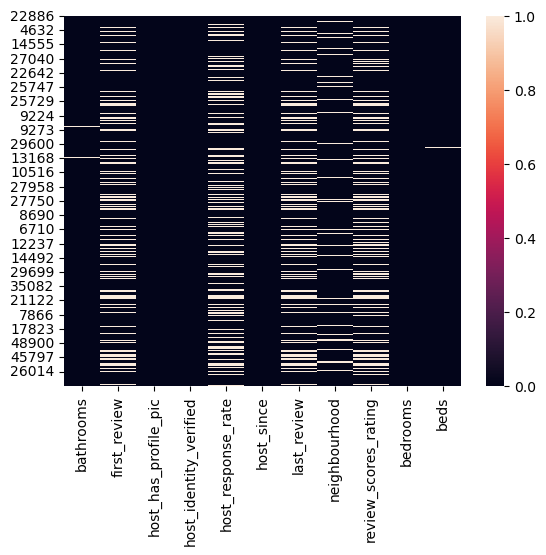

In [14]:
sns.heatmap(train[train.columns[train.isna().any()].tolist()].isna())
plt.show()

In [15]:
# Se imputan medianas y modas a las columnas en las que hay nulos:
train[columnas_numericas] = train[columnas_numericas].fillna(train[columnas_numericas].median())
test[columnas_numericas] = test[columnas_numericas].fillna(test[columnas_numericas].median())
train[columnas_categoricas] = train[columnas_categoricas].fillna(train[columnas_categoricas].mode())
test[columnas_categoricas] = test[columnas_categoricas].fillna(test[columnas_categoricas].mode())

In [16]:
# Sigue habiendo nulos:
train[train.columns[train.isna().any()]].isna().sum()

host_has_profile_pic       111
host_identity_verified     111
neighbourhood             3435
dtype: int64

In [17]:
# Se toma la decisión de eliminar la columna neighbourhood y las filas que tengan nulos en el resto de columnas:
train.drop(["neighbourhood"], axis=1, inplace=True)
train.dropna(inplace=True)
test.drop(["neighbourhood"], axis=1, inplace=True)
test.dropna(inplace=True)


In [18]:
# Columnas con nulos:
print(f"Columnas con nulos en el train set: {train.columns[train.isna().any()].tolist()}")
print(f"Columnas con nulos en el test set: {test.columns[test.isna().any()].tolist()}")

Columnas con nulos en el train set: []
Columnas con nulos en el test set: []


## Tratamiento de duplicados

In [19]:
# Duplicados
print(f"Filas duplicadas en el train set: {train[train.duplicated()].shape[0]}.")
print(f"Filas duplicadas en el test set: {test[test.duplicated()].shape[0]}.")

Filas duplicadas en el train set: 0.
Filas duplicadas en el test set: 0.


## Limpieza de columnas numéricas

In [20]:
print(f"Columnas numéricas: {columnas_numericas}")

Columnas numéricas: ['id', 'log_price', 'accommodates', 'bathrooms', 'first_review', 'host_response_rate', 'host_since', 'last_review', 'latitude', 'longitude', 'number_of_reviews', 'review_scores_rating', 'bedrooms', 'beds', 'price']


### Columna *id*

In [21]:
train.id.value_counts()
# No hay valores repetidos, es una columna identificadora. No interesa tener una columna que identifique de forma única a las habitaciones en el problema.

id
10011086    1
9637712     1
9902985     1
9365581     1
14907455    1
           ..
8186531     1
17410346    1
13642074    1
12535960    1
15551602    1
Name: count, Length: 41762, dtype: int64

In [184]:
# Se procede a la eliminación de la columna:
train.drop(["id"], axis=1, inplace=True)
test.drop(["id"], axis=1, inplace=True)

### Columna *log_price*

In [22]:
# Se elimina dicha columna porque se tiene la columna price, que es la que muestra realmente los valores de los precios de las habitaciones y no su logaritmo neperiano.
train.drop(["log_price"], axis=1, inplace=True)
test.drop(["log_price"], axis=1, inplace=True)

### Columnas *review_scores_rating*, *bedrooms* y *beds*

In [23]:
# Son valores enteros pero vienen en tipo decimal. Se transforman a tipo entero:
train[["review_scores_rating","bedrooms","beds"]].head()

,review_scores_rating,bedrooms,beds
22886,97.0,2.0,2.0
10115,100.0,1.0,1.0
5972,90.0,1.0,1.0
31282,100.0,1.0,1.0
23369,96.0,1.0,1.0


In [24]:
train[["review_scores_rating","bedrooms","beds"]] = train[["review_scores_rating","bedrooms","beds"]].astype("int")
test[["review_scores_rating","bedrooms","beds"]] = test[["review_scores_rating","bedrooms","beds"]].astype("int")

In [25]:
columnas_numericas = list(train.loc[:,:"price"].select_dtypes(include=["number","datetime"]).columns)
columnas_categoricas = list(train.loc[:,:"price"].select_dtypes(exclude=["number","datetime"]).columns)
print(f"Columnas numéricas: {columnas_numericas}")
print(f"Columnas categóricas: {columnas_categoricas}")

Columnas numéricas: ['id', 'accommodates', 'bathrooms', 'first_review', 'host_response_rate', 'host_since', 'last_review', 'latitude', 'longitude', 'number_of_reviews', 'review_scores_rating', 'bedrooms', 'beds', 'price']
Columnas categóricas: ['property_type', 'room_type', 'bed_type', 'cancellation_policy', 'cleaning_fee', 'city', 'host_has_profile_pic', 'host_identity_verified', 'instant_bookable', 'zipcode']


### Columna *processed_date*

In [26]:
# Se elimina dicha columna porque fue generada durante el proceso de ETL por el linaje de los datos (processed_date):
train.drop(["processed_date"], axis=1, inplace=True)
test.drop(["processed_date"], axis=1, inplace=True)

### Columnas de fechas: *first_review*, *host_since* y *last_review*

In [28]:
# Se convierten a tipo entero
columnas_fechas = ["first_review", "host_since", "last_review"]
for columna in columnas_fechas:
    train[columna] = pd.to_datetime(train[columna]).astype("int64")
    test[columna] = pd.to_datetime(test[columna]).astype("int64")
for columna in columnas_fechas:
    train[columna] = (train[columna] - train[columna].min()) / train[columna].max()
    test[columna] = (test[columna] - test[columna].min()) / test[columna].max()

### Tratamiento de valores anómalos

In [29]:
def detect_outliers(df):
    # Lista para almacenar las columnas con outliers
    columns_with_outliers = []
    
    # Iterar a través de cada columna del DataFrame
    for col in df.columns:
        if pd.api.types.is_numeric_dtype(df[col]) and not pd.api.types.is_bool_dtype(df[col]):
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            # Detectar los outliers
            outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
            if not outliers.empty:
                columns_with_outliers.append(col)
    
    return columns_with_outliers

In [30]:
def detect_and_replace_outliers_with_median(df, columns):
    # Crear una copia del DataFrame para evitar modificar el original
    df_cleaned = df.copy()
    
    # Iterar a través de cada columna especificada en la lista
    for col in columns:
        # Verificar si la columna existe en el DataFrame y es numérica
        if col in df.columns and pd.api.types.is_numeric_dtype(df[col]) and not pd.api.types.is_bool_dtype(df[col]):
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            # Calcular la mediana de la columna
            col_median = df[col].median()

            # Identificar los índices de las filas que son outliers
            outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)].index

            # Reemplazar los valores de los outliers con la mediana de la columna
            df_cleaned.loc[outliers, col] = col_median
    
    return df_cleaned

In [31]:
while detect_outliers(train.loc[:,:"price"]):
    train = detect_and_replace_outliers_with_median(train, detect_outliers(train.loc[:,:"price"]))

In [32]:
while detect_outliers(test.loc[:,:"price"]):
    test = detect_and_replace_outliers_with_median(test, detect_outliers(test.loc[:,:"price"]))

## Limpieza de columnas categóricas

In [33]:
print(f"Columnas categóricas: {columnas_categoricas}")

Columnas categóricas: ['property_type', 'room_type', 'bed_type', 'cancellation_policy', 'cleaning_fee', 'city', 'host_has_profile_pic', 'host_identity_verified', 'instant_bookable', 'zipcode']


### Columna *property_type*

In [34]:
train.property_type.value_counts(normalize=True) * 100

property_type
Apartment             67.566209
House                 21.119678
Condominium            3.575020
Townhouse              2.169436
Loft                   1.606724
Other                  0.840477
Bed & Breakfast        0.656099
Guesthouse             0.601025
Bungalow               0.433408
Villa                  0.237058
Dorm                   0.193956
Guest suite            0.158038
Timeshare              0.136488
Camper/RV              0.129304
Hostel                 0.112543
In-law                 0.088597
Boutique hotel         0.086203
Boat                   0.076625
Cabin                  0.069441
Serviced apartment     0.031129
Tent                   0.026340
Castle                 0.019156
Yurt                   0.014367
Vacation home          0.011973
Hut                    0.009578
Treehouse              0.007184
Earth House            0.007184
Chalet                 0.004789
Cave                   0.004789
Parking Space          0.002395
Train                  0.0

In [35]:
# Como hay varias clases de las que no hay mucha representación, se asignan a la clase "Other" aquellas clases que no representan ni un 1 % de los datos:
clases = list(train.property_type.value_counts(normalize=True).tail(26).index)
print(f"Clases que se asignan a \"Other\" en la columna property_type: {clases}")

Clases que se asignan a "Other" en la columna property_type: ['Bed & Breakfast', 'Guesthouse', 'Bungalow', 'Villa', 'Dorm', 'Guest suite', 'Timeshare', 'Camper/RV', 'Hostel', 'In-law', 'Boutique hotel', 'Boat', 'Cabin', 'Serviced apartment', 'Tent', 'Castle', 'Yurt', 'Vacation home', 'Hut', 'Treehouse', 'Earth House', 'Chalet', 'Cave', 'Parking Space', 'Train', 'Lighthouse']


In [36]:
train["property_type"] = train["property_type"].apply(lambda x: "Other" if x in clases else x)
test["property_type"] = test["property_type"].apply(lambda x: "Other" if x in clases else x)

In [37]:
train.property_type.value_counts()

property_type
Apartment      28217
House           8820
Other           1655
Condominium     1493
Townhouse        906
Loft             671
Name: count, dtype: int64

### Columna *bed_type*

In [38]:
# Se elimina la columna porque apenas hay variabilidad.
train.bed_type.value_counts(normalize=True)

bed_type
Real Bed         0.970619
Futon            0.010656
Pull-out Sofa    0.008022
Airbed           0.006585
Couch            0.004119
Name: proportion, dtype: float64

In [39]:
train.drop(["bed_type"], axis=1, inplace=True)
test.drop(["bed_type"], axis=1, inplace=True)

### Columna *cancellation_policy*

In [40]:
# Se aplica un ordinal encoding porque la categoría es ordenada:
train["cancellation_policy"] = train["cancellation_policy"].apply(lambda x: 3 if x in ["super_strict_30", "super_strict_60"] else 2 if x == "strict" else 1 if x == "moderate" else 0)
test["cancellation_policy"] = test["cancellation_policy"].apply(lambda x: 3 if x in ["super_strict_30", "super_strict_60"] else 2 if x == "strict" else 1 if x == "moderate" else 0)

In [41]:
train.cancellation_policy.value_counts(normalize=True) * 100

cancellation_policy
2    41.410852
0    32.531967
1    25.982951
3     0.074230
Name: proportion, dtype: float64

### Columnas *cleaning_fee*, *host_has_profile_pic*, *host_identity_verified* y *instant_bookable*

In [42]:
# Se transforman a 1 (True) y 0 (False)
train["cleaning_fee"] = train["cleaning_fee"].apply(lambda x: 1 if x else 0)
test["cleaning_fee"] = test["cleaning_fee"].apply(lambda x: 1 if x else 0)
train["host_has_profile_pic"] = train["host_has_profile_pic"].apply(lambda x: 1 if x else 0)
test["host_has_profile_pic"] = test["host_has_profile_pic"].apply(lambda x: 1 if x else 0)
train["host_identity_verified"] = train["host_identity_verified"].apply(lambda x: 1 if x else 0)
test["host_identity_verified"] = test["host_identity_verified"].apply(lambda x: 1 if x else 0)
train["instant_bookable"] = train["instant_bookable"].apply(lambda x: 1 if x else 0)
test["instant_bookable"] = test["instant_bookable"].apply(lambda x: 1 if x else 0)

### Columna host_has_profile_pic

In [43]:
# Se elimina la columna porque apenas hay variabilidad.
train["host_has_profile_pic"].value_counts(normalize=True)

host_has_profile_pic
1    0.996887
0    0.003113
Name: proportion, dtype: float64

In [44]:
train.drop(["host_has_profile_pic"], axis=1, inplace=True)
test.drop(["host_has_profile_pic"], axis=1, inplace=True)

### Columna *zipcode*

In [45]:
print(f"Cantidad de códigos postales diferentes: {train.zipcode.nunique()}.")
# Como son muchos códigos postales, se elimina la columna.
train.drop(["zipcode"], axis=1, inplace=True)
test.drop(["zipcode"], axis=1, inplace=True)

Cantidad de códigos postales diferentes: 617.


# Visualización de los datos

## Distribución de las variables, correlaciones y balanceo de los datos

In [46]:
columnas_numericas = list(train.loc[:,:"price"].select_dtypes(include=["number","datetime"]).columns)
columnas_categoricas = list(train.loc[:,:"price"].select_dtypes(exclude=["number","datetime"]).columns)

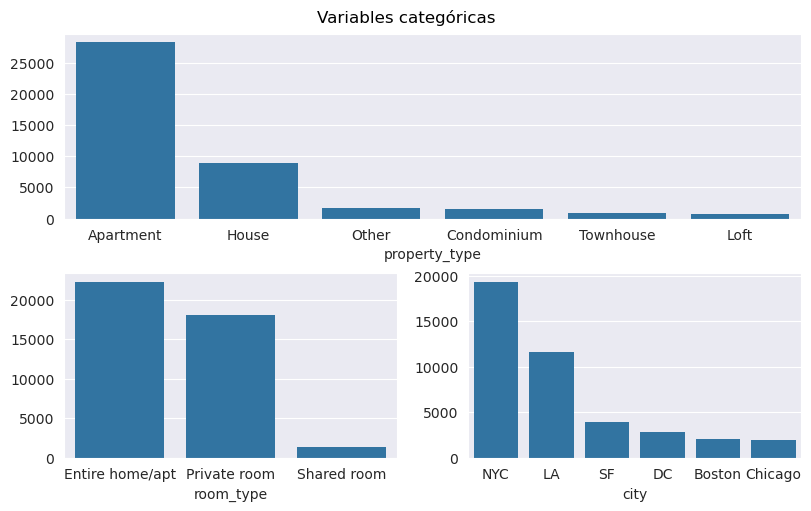

In [49]:
fig = plt.figure(layout="constrained", figsize=(8,5))

gs = GridSpec(2, 2, figure=fig)
with sns.axes_style("darkgrid"):
    ax1 = fig.add_subplot(gs[0, :])
    ax2 = fig.add_subplot(gs[1, 0])
    ax3 = fig.add_subplot(gs[1, 1])
sns.countplot(train[columnas_categoricas], x="property_type", order=train['property_type'].value_counts().index, ax=ax1)
ax1.set_ylabel("")
sns.countplot(train[columnas_categoricas], x="room_type", order=train['room_type'].value_counts().index, ax=ax2)
ax2.set_ylabel("")
sns.countplot(train[columnas_categoricas], x="city", order=train['city'].value_counts().index, ax=ax3)
ax3.set_ylabel("")

fig.suptitle("Variables categóricas")

plt.show()

In [50]:
columnas = ["cleaning_fee","host_identity_verified","instant_bookable"]

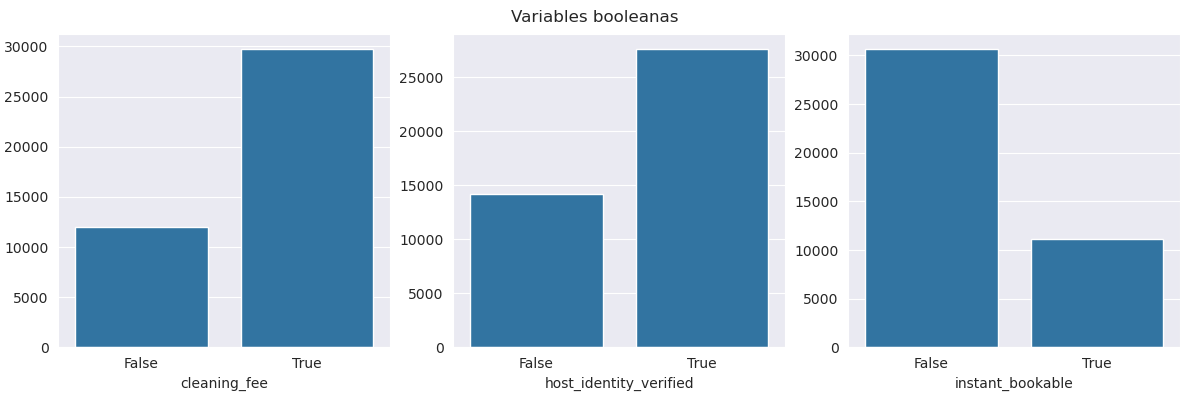

In [51]:
with sns.axes_style("darkgrid"):
    fig, axes = plt.subplots(1, len(columnas), figsize=(12,4))
    for i, columna in enumerate(columnas):
        ax = sns.countplot(x=train[columna], ax=axes[i])
        ax.set_xticks(np.arange(2), ['False', 'True'])
        ax.set_ylabel("")
    fig.tight_layout()
    fig.subplots_adjust(top=.92)
    plt.suptitle("Variables booleanas")

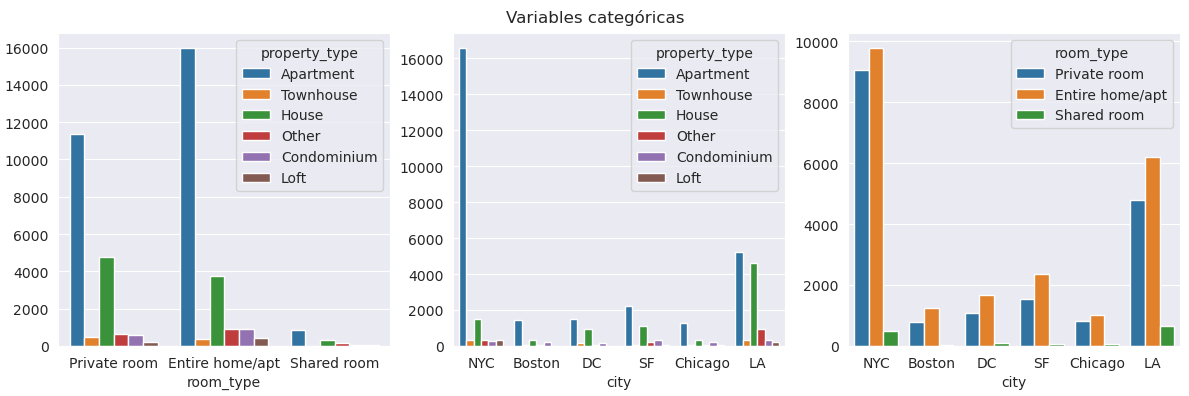

In [52]:
with sns.axes_style("darkgrid"):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    sns.countplot(hue=train["property_type"], x=train["room_type"], ax=axes[0], order=["Private room","Entire home/apt","Shared room"])
    sns.countplot(hue=train["property_type"], x=train["city"], ax=axes[1], order=["NYC","Boston","DC","SF","Chicago","LA"])
    sns.countplot(hue=train["room_type"], x=train["city"], ax=axes[2], order=["NYC","Boston","DC","SF","Chicago","LA"], hue_order=["Private room","Entire home/apt","Shared room"])
    [ax.set_ylabel("") for ax in axes]
    fig.tight_layout()
    fig.subplots_adjust(top=.92)
    plt.suptitle("Variables categóricas")

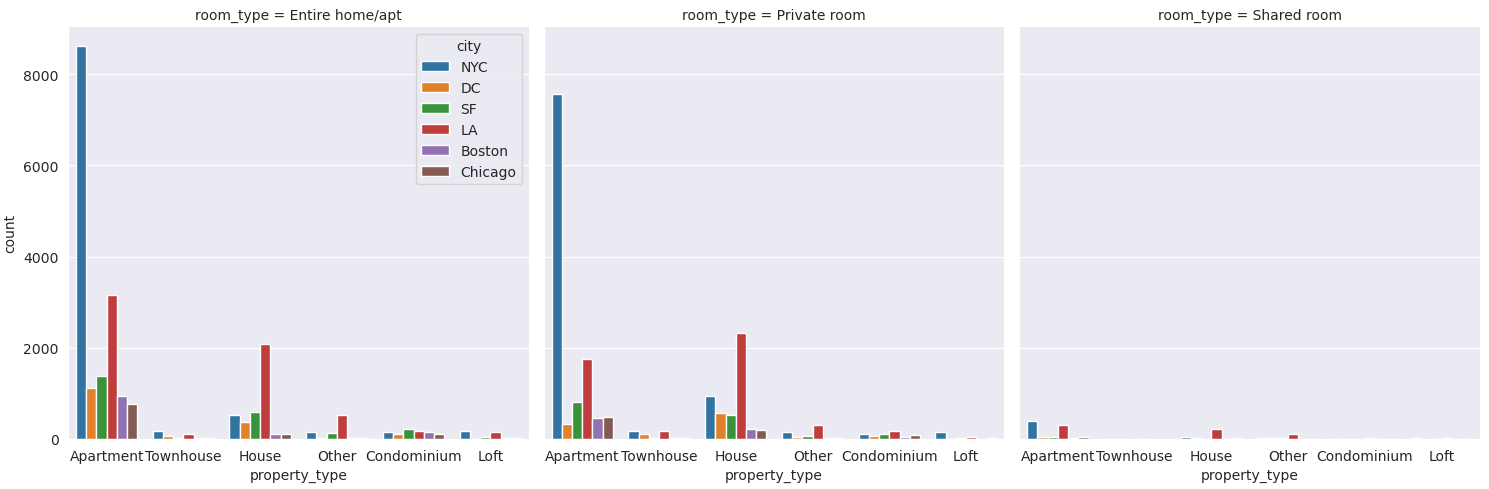

In [53]:
with sns.axes_style("darkgrid"):
    ax = sns.catplot(x='property_type', hue='city', col='room_type', data=train, kind='count', legend_out=False)

In [54]:
columnas = ['accommodates', 'bathrooms', 'cancellation_policy', 'host_response_rate', 'number_of_reviews', 'review_scores_rating', 'bedrooms', 'beds', 'price']

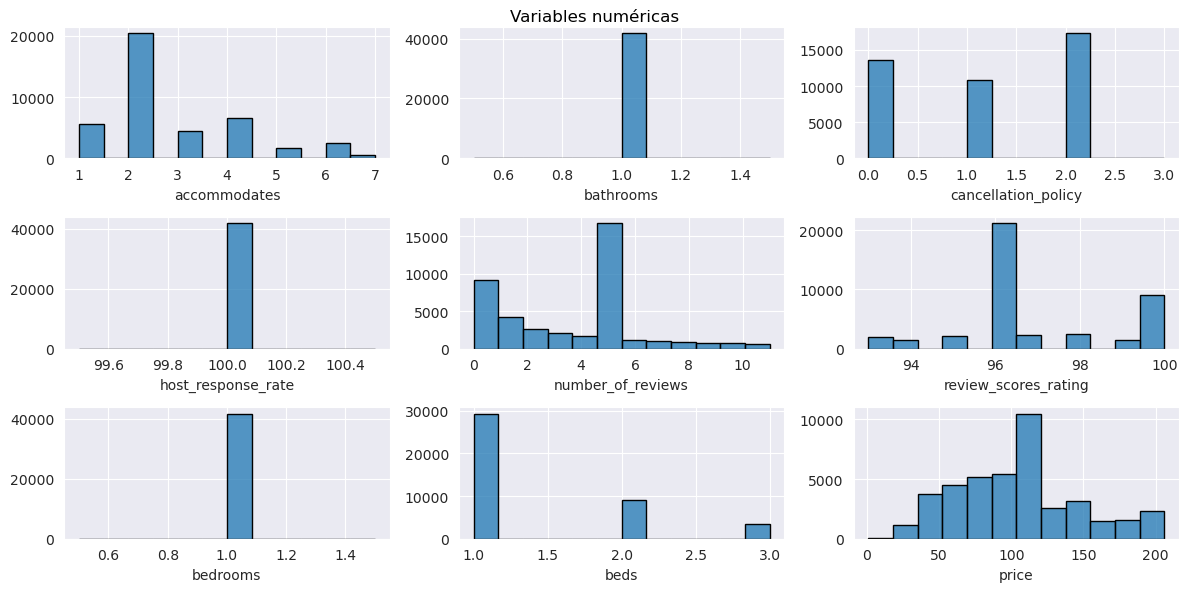

In [55]:
with sns.axes_style("darkgrid"):
    fig, axes = plt.subplots(len(columnas) // 3, 3, figsize=(12, 6))
for i, col in enumerate(columnas):
    ax = sns.histplot(data=train, x=train[col], ax=axes[i // 3, i % 3], bins=12)
    ax.set_title("")
    ax.set_ylabel("")
fig.tight_layout()
fig.subplots_adjust(top=.95)
fig.suptitle("Variables numéricas")
plt.show()

In [56]:
train[columnas].skew()

accommodates            1.079525
bathrooms               0.000000
cancellation_policy    -0.166668
host_response_rate      0.000000
number_of_reviews       0.327331
review_scores_rating    0.356961
bedrooms                0.000000
beds                    1.434340
price                   0.417466
dtype: float64

### Tratamiento de *skewness* positivo: columnas *beds* y *accommodates*

In [57]:
print(f"Skewness de las columnas beds y accommodates: \n{train.beds.skew()} y {train.accommodates.skew()}.")
train.beds = train.beds.apply(lambda x: np.log(x + .1))
train.accommodates  = train.accommodates.apply(lambda x: np.log(x + .1))
test.beds = test.beds.apply(lambda x: np.log(x + .1))
test.accommodates  = test.accommodates.apply(lambda x: np.log(x + .1))
print(f"Skewness de las columnas beds y accommodates después de aplicar el cambio: \n{train.beds.skew()} y {train.accommodates.skew()}.")

Skewness de las columnas beds y accommodates: 
1.4343396862127096 y 1.0795248269288065.
Skewness de las columnas beds y accommodates después de aplicar el cambio: 
1.1397471815892117 y 0.1219017054283504.


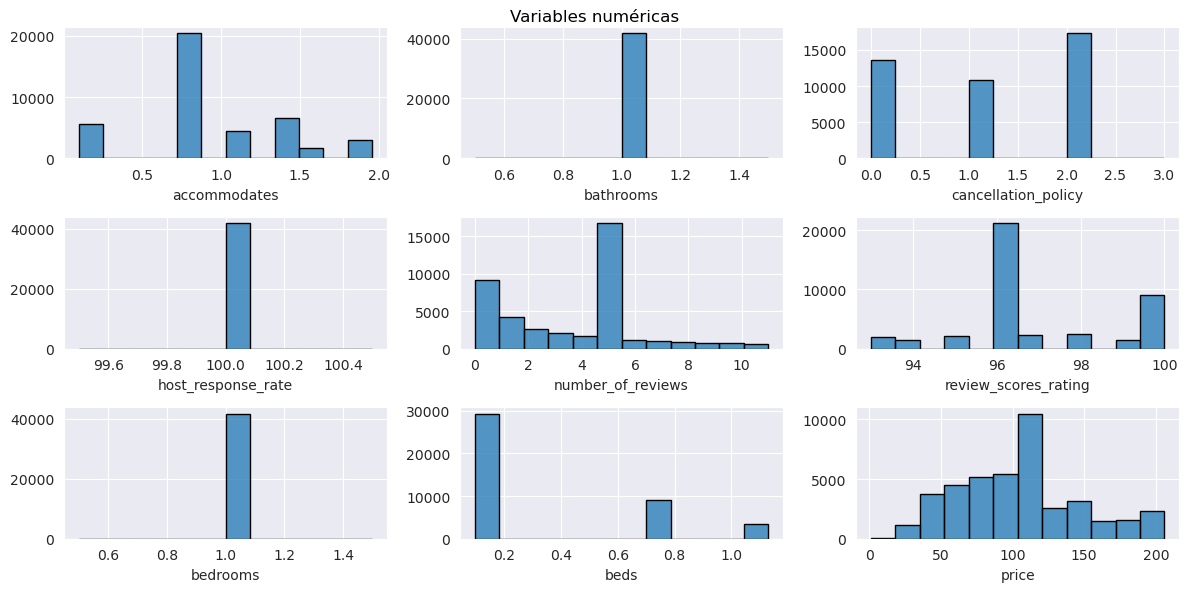

In [58]:
with sns.axes_style("darkgrid"):
    fig, axes = plt.subplots(len(columnas) // 3, 3, figsize=(12, 6))
for i, col in enumerate(columnas):
    ax = sns.histplot(data=train, x=train[col], ax=axes[i // 3, i % 3], bins=12)
    ax.set_title("")
    ax.set_ylabel("")
fig.tight_layout()
fig.subplots_adjust(top=.95)
fig.suptitle("Variables numéricas")
plt.show()

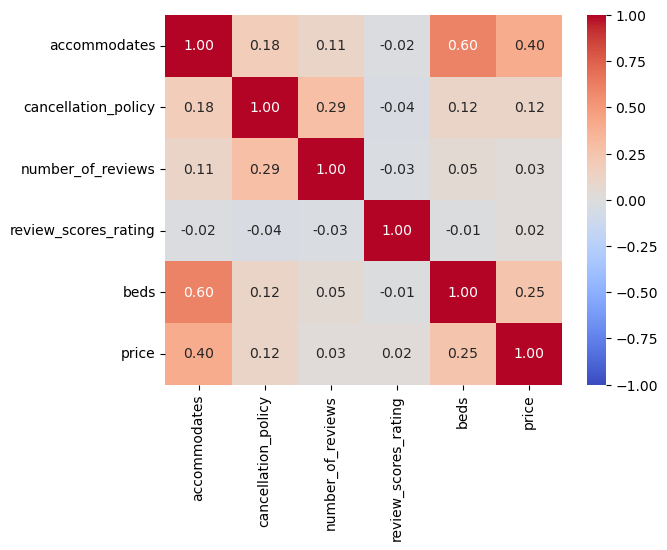

In [59]:
sns.heatmap(train[train[columnas].corr().sum()[train[columnas].corr().sum() != 0].index].corr(), annot = True, vmin = -1, vmax = 1, center = 0, cmap = 'coolwarm', fmt=".2f")
plt.show()

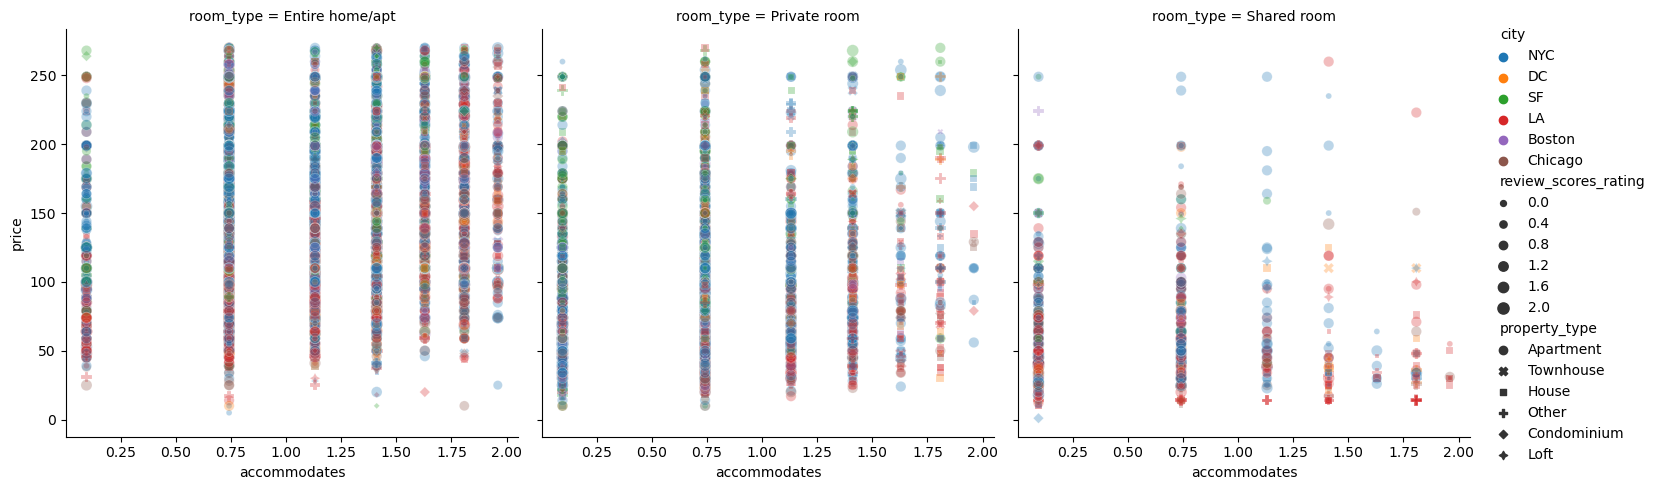

In [228]:
g = sns.relplot(train, x="accommodates", y="price", hue="city", style="property_type", col="room_type", size="review_scores_rating", alpha=0.3)
for lh in g.legend.legend_handles:
    lh.set_alpha(1) 
plt.show()

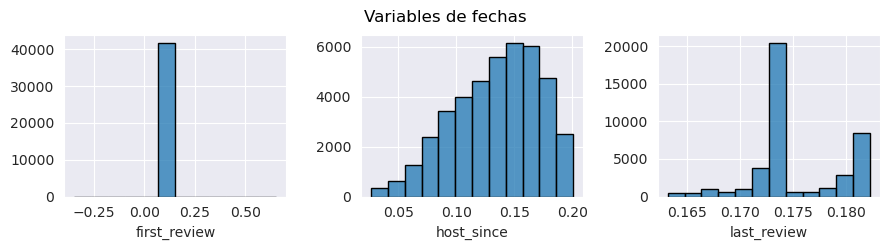

In [61]:
with sns.axes_style("darkgrid"):
    fig, axes = plt.subplots(len(columnas_fechas) // 3, 3, figsize=(9, 2.5))
for i, col in enumerate(columnas_fechas):
    ax = sns.histplot(data=train, x=train[col], ax=axes[i], bins=12)
    ax.set_title("")
    ax.set_ylabel("")
fig.tight_layout()
fig.subplots_adjust(top=.88)
fig.suptitle("Variables de fechas")
plt.show()

# OneHotEncoder, escalado de datos y reducción de dimensionalidad

In [63]:
X_train = train.copy()
X_test = test.copy()
y_train = X_train["price"]
y_test = X_test["price"]
X_train.drop(["price"], axis=1, inplace=True)
X_test.drop(["price"], axis=1, inplace=True)

In [64]:
cat_encoder = OneHotEncoder(sparse_output=False)
columnas_categoricas = list(X_train.select_dtypes(include="object").columns)
cat_encoder.fit(X_train[columnas_categoricas])
columnas = [cateogria + ": " + str(cat) for index, cateogria in enumerate(columnas_categoricas) for cat in cat_encoder.categories_[index]]
X_train_1hot = pd.DataFrame(cat_encoder.transform(X_train[columnas_categoricas]), columns=columnas)
X_test_1hot = pd.DataFrame(cat_encoder.transform(X_test[columnas_categoricas]), columns=columnas)
X_train_1hot.index = X_train.index
X_test_1hot.index = X_test.index
X_train = pd.concat([X_train.drop(columnas_categoricas, axis=1), X_train_1hot], axis=1)
X_test = pd.concat([X_test.drop(columnas_categoricas, axis=1), X_test_1hot], axis=1)

In [66]:
transformer = StandardScaler()
X_train = pd.DataFrame(transformer.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(transformer.transform(X_test), columns=X_test.columns) 

In [67]:
pca = PCA(n_components=0.95, svd_solver="full")
X_train_pca = pca.fit_transform(X_train)
columnas = ["X{}".format(i) for i in range(X_train_pca.shape[1])]
X_train = pd.DataFrame(X_train_pca, columns=columnas)
X_test = pd.DataFrame(pca.transform(X_test), columns=columnas)

# Pipeline

In [4]:
train, test = train_test_split(df, test_size=0.2, random_state=0)

def detect_outliers(df):
    # Lista para almacenar las columnas con outliers
    columns_with_outliers = []
    # Iterar a través de cada columna del DataFrame
    for col in df.columns:
        if pd.api.types.is_numeric_dtype(df[col]) and not pd.api.types.is_bool_dtype(df[col]):
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            # Detectar los outliers
            outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
            if not outliers.empty:
                columns_with_outliers.append(col)
    return columns_with_outliers

def detect_and_replace_outliers_with_median(df, columns):
    # Crear una copia del DataFrame para evitar modificar el original
    df_cleaned = df.copy()
    # Iterar a través de cada columna especificada en la lista
    for col in columns:
        # Verificar si la columna existe en el DataFrame y es numérica
        if col in df.columns and pd.api.types.is_numeric_dtype(df[col]) and not pd.api.types.is_bool_dtype(df[col]):
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            # Calcular la mediana de la columna
            col_median = df[col].median()
            # Identificar los índices de las filas que son outliers
            outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)].index
            # Reemplazar los valores de los outliers con la mediana de la columna
            df_cleaned.loc[outliers, col] = col_median
    return df_cleaned

def mis_transformaciones(df): 
    df["first_review"] = pd.to_datetime(df["first_review"])
    df["host_since"] = pd.to_datetime(df["host_since"])
    df["last_review"] = pd.to_datetime(df["last_review"])
    df["processed_date"] = pd.to_datetime(df["processed_date"])
    df["host_response_rate"] = df["host_response_rate"].apply(lambda x: float(x[:-1]) if type(x) == str else np.nan)
    df["zipcode"] = df.zipcode.apply(lambda x: str(int(float(x))).zfill(5))
    columnas_numericas = list(df.loc[:,:"price"].select_dtypes(include=["number","datetime"]).columns)
    columnas_categoricas = list(df.loc[:,:"price"].select_dtypes(exclude=["number","datetime"]).columns)
    df[columnas_numericas] = df[columnas_numericas].fillna(df[columnas_numericas].median())
    df[columnas_categoricas] = df[columnas_categoricas].fillna(df[columnas_categoricas].mode())
    df.drop(["neighbourhood"], axis=1, inplace=True)
    df.dropna(inplace=True)
    df.drop(["id","log_price"], axis=1, inplace=True)
    df[["review_scores_rating","bedrooms","beds"]] = df[["review_scores_rating","bedrooms","beds"]].astype("int")
    df.drop(["processed_date"], axis=1, inplace=True)
    columnas_fechas = list(df.loc[:,:"price"].select_dtypes(include=["datetime"]).columns)
    for columna in columnas_fechas:
        df[columna] = df[columna].astype("int64")
    for columna in columnas_fechas:
        df[columna] = (df[columna] - df[columna].min()) / df[columna].max()
    while detect_outliers(df.loc[:,:"price"]):
        df = detect_and_replace_outliers_with_median(df, detect_outliers(df.loc[:,:"price"]))
    clases = list(df.property_type.value_counts(normalize=True).tail(26).index)
    df["property_type"] = df["property_type"].apply(lambda x: "Other" if x in clases else x)
    df.drop(["bed_type"], axis=1, inplace=True)
    df["cancellation_policy"] = df["cancellation_policy"].apply(lambda x: 3 if x in ["super_strict_30", "super_strict_60"] else 2 if x == "strict" else 1 if x == "moderate" else 0)
    df["cleaning_fee"] = df["cleaning_fee"].apply(lambda x: 1 if x else 0)
    df["host_has_profile_pic"] = df["host_has_profile_pic"].apply(lambda x: 1 if x else 0)
    df["host_identity_verified"] = df["host_identity_verified"].apply(lambda x: 1 if x else 0)
    df["instant_bookable"] = df["instant_bookable"].apply(lambda x: 1 if x else 0)
    df.drop(["host_has_profile_pic"], axis=1, inplace=True)
    df.drop(["zipcode"], axis=1, inplace=True)
    df["beds"] = df["beds"].apply(lambda x: np.log(x + .1))
    df["accommodates"]  = df["accommodates"].apply(lambda x: np.log(x + .1))
    X_df = df.copy()
    y_df = df["price"]
    X_df.drop(["price"], axis=1, inplace=True)
    return X_df, y_df

funcion_transformadora = FunctionTransformer(mis_transformaciones)
X_train, y_train = funcion_transformadora.fit_transform(train)
X_test, y_test = funcion_transformadora.transform(test)

cat_encoder = OneHotEncoder(sparse_output=False)
columnas_categoricas = list(X_train.select_dtypes(include="object").columns)
cat_encoder.fit(X_train[columnas_categoricas])
columnas = [cateogria + ": " + str(cat) for index, cateogria in enumerate(columnas_categoricas) for cat in cat_encoder.categories_[index]]
X_train_1hot = pd.DataFrame(cat_encoder.transform(X_train[columnas_categoricas]), columns=columnas)
X_test_1hot = pd.DataFrame(cat_encoder.transform(X_test[columnas_categoricas]), columns=columnas)
X_train_1hot.index = X_train.index
X_test_1hot.index = X_test.index
X_train = pd.concat([X_train.drop(columnas_categoricas, axis=1), X_train_1hot], axis=1)
X_test = pd.concat([X_test.drop(columnas_categoricas, axis=1), X_test_1hot], axis=1)

transformer = StandardScaler()
X_train = pd.DataFrame(transformer.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(transformer.transform(X_test), columns=X_test.columns)

pca = PCA(n_components=0.95, svd_solver="full")
X_train_pca = pca.fit_transform(X_train)
columnas = ["X{}".format(i) for i in range(X_train_pca.shape[1])]
X_train = pd.DataFrame(X_train_pca, columns=columnas)
X_test = pd.DataFrame(pca.transform(X_test), columns=columnas)

# Entrenamiento de modelos

### Regresión lineal

#### LinearRegression

In [5]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression()

In [6]:
some_data = X_train.iloc[:5]
print("Predictions:", lin_reg.predict(some_data))

some_labels = y_train.iloc[:5]
print("Labels:", list(some_labels))

Predictions: [120.01294048  89.66054363  78.84090229  90.96575372  82.9236201 ]
Labels: [199, 95, 59, 74, 55]


In [7]:
from sklearn.metrics import mean_squared_error

predictions = lin_reg.predict(X_train)
lin_mse = mean_squared_error(y_train, predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

33.46017653510424

In [8]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(y_train, predictions)
lin_mae

26.540242572933156

#### Decision-Tree

In [9]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

In [10]:
predictions = tree_reg.predict(X_train)
tree_mse = mean_squared_error(y_train, predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

##### Overfitting

#### Cross-val

In [11]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, X_train, y_train, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [12]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [49.08124771 48.01150259 48.00120479 47.73517352 48.38316644 48.39649806
 48.10688132 48.70213044 48.44060134 48.40913349]
Mean: 48.32675397144793
Standard deviation: 0.36628399224113883


In [13]:
lin_scores = cross_val_score(lin_reg, X_train, y_train, scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [ 33.91001048  33.35884715  32.79853667  33.87403907  34.40717928
 500.63484232  33.95345839  33.76648162  33.03473465  33.41772496]
Mean: 80.31558545798184
Standard deviation: 140.10714233392522


#### Random Forest

In [14]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [15]:
predictions = forest_reg.predict(X_train)
forest_mse = mean_squared_error(y_train, predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

12.561250970911168

In [16]:
forest_scores = cross_val_score(forest_reg, X_train, y_train, scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [34.06996414 33.26171791 32.95519757 33.60014635 34.27360801 33.46486312
 34.14680231 33.44591018 32.70498807 33.29476148]
Mean: 33.52179591435511
Standard deviation: 0.48773717799753863


#### SVR

In [17]:
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
svm_reg.fit(X_train, y_train)
predictions = svm_reg.predict(X_train)
svm_mse = mean_squared_error(y_train, predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

34.76117004747129

In [18]:
svm_scores = cross_val_score(svm_reg, X_train, y_train, scoring="neg_mean_squared_error", cv=10)
svm_rmse_scores = np.sqrt(-svm_scores)
display_scores(svm_rmse_scores)

Scores: [35.13359402 34.71346574 34.2452424  35.15928821 36.17867385 36.56314574
 35.02935679 35.1406478  34.27735699 34.39441269]
Mean: 35.083518421865406
Standard deviation: 0.7326333963966328


#### Xg-Boost

In [19]:
import xgboost as xgb # conda install xgboost

xgb_reg = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)
xgb_reg.fit(X_train, y_train)
predictions = xgb_reg.predict(X_train)
xgb_mse = mean_squared_error(y_train, predictions)
xgb_rmse = np.sqrt(xgb_mse)
xgb_rmse

23.34021653282739

In [20]:
xgb_scores = cross_val_score(xgb_reg, X_train, y_train, scoring="neg_mean_squared_error", cv=10)
xgb_rmse_scores = np.sqrt(-xgb_scores)
display_scores(xgb_rmse_scores)

Scores: [35.05338029 34.00806584 33.52990047 34.07976625 35.11279165 33.9837301
 35.01539026 34.17071048 33.61456147 33.75805203]
Mean: 34.2326348833098
Standard deviation: 0.5746018204708626


#### TestSet

In [40]:
predictions = lin_reg.predict(X_test)

final_mse = mean_squared_error(y_test, predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

99.7153713893489

In [21]:
predictions = tree_reg.predict(X_test)

final_mse = mean_squared_error(y_test, predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

51.387751231565915

In [22]:
predictions = forest_reg.predict(X_test)

final_mse = mean_squared_error(y_test, predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

34.24588773938556

In [23]:
predictions = svm_reg.predict(X_test)

final_mse = mean_squared_error(y_test, predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

36.43691004541605

In [24]:
predictions = xgb_reg.predict(X_test)

final_mse = mean_squared_error(y_test, predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

35.58747680974997

In [25]:
a = # Celda para parar la ejecución de código.

SyntaxError: invalid syntax (3545649324.py, line 1)

### Red Neuronal

Voy a cambiar las columnas de price, calculando la mediana de y_train, y luego cambiando los valores del mismo por un 1 o un 0 dependiendo de si está por encima o por debajo de la mediana. En el y_test haré lo mismo pero tomando como valor límite la mediana de y_train tambien.

In [26]:
y_train

22886    199
10115     95
5972      59
31282     74
23369     55
        ... 
21243     85
45891    125
42613     74
43567     48
2732     179
Name: price, Length: 41762, dtype: int64

In [27]:
mediana_columna = y_train.median()
mediana_columna

110.0

In [28]:
y_train= y_train.apply(lambda x: 1 if x > mediana_columna else 0)

In [29]:
y_train

22886    1
10115    0
5972     0
31282    0
23369    0
        ..
21243    0
45891    1
42613    0
43567    0
2732     1
Name: price, Length: 41762, dtype: int64

In [30]:
y_test= y_test.apply(lambda x: 1 if x > mediana_columna else 0)

In [31]:
y_test

5739     1
33347    0
14292    0
52061    1
18950    1
        ..
51064    0
5911     1
29031    1
34035    0
37598    0
Name: price, Length: 10444, dtype: int64

In [35]:
import torch
import torch.nn as nn

class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.fc1 = nn.Linear(114, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.3)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.sigmoid(self.fc3(x))
        return x

model = SimpleModel()

In [36]:
import torch.optim as optim

criterion = nn.BCELoss()  
optimizer = optim.Adam(model.parameters(), lr=0.001,weight_decay=1e-4)  

In [37]:
import numpy as np
from sklearn.metrics import accuracy_score

num_epochs = 50
batch_size = 14

# Convertir DataFrames de pandas a arrays de numpy
X_train_np = X_train.to_numpy().astype(np.float32)
y_train_np = y_train.to_numpy().astype(np.float32)
X_val_np = X_test.to_numpy().astype(np.float32)
y_val_np = y_test.to_numpy().astype(np.float32)

train_data = torch.utils.data.TensorDataset(torch.tensor(X_train_np), torch.tensor(y_train_np))
val_data = torch.utils.data.TensorDataset(torch.tensor(X_val_np), torch.tensor(y_val_np))

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0.0
    epoch_train_preds = []
    epoch_train_labels = []
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
        epoch_train_preds.extend(outputs.detach().cpu().numpy())
        epoch_train_labels.extend(labels.detach().cpu().numpy())
    
    epoch_train_loss /= len(train_loader)
    epoch_train_preds = np.array(epoch_train_preds)
    epoch_train_preds = (epoch_train_preds > 0.5).astype(int)
    epoch_train_accuracy = accuracy_score(epoch_train_labels, epoch_train_preds)
    
    model.eval()
    epoch_val_loss = 0.0
    epoch_val_preds = []
    epoch_val_labels = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)
            epoch_val_loss += loss.item()
            epoch_val_preds.extend(outputs.cpu().numpy())
            epoch_val_labels.extend(labels.cpu().numpy())
    
    epoch_val_loss /= len(val_loader)
    epoch_val_preds = np.array(epoch_val_preds)
    epoch_val_preds = (epoch_val_preds > 0.5).astype(int)
    epoch_val_accuracy = accuracy_score(epoch_val_labels, epoch_val_preds)
    
    train_losses.append(epoch_train_loss)
    val_losses.append(epoch_val_loss)
    train_accuracies.append(epoch_train_accuracy)
    val_accuracies.append(epoch_val_accuracy)

    # print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {epoch_train_accuracy:.4f}, Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {epoch_val_accuracy:.4f}')
    print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {epoch_val_loss}')

Epoch 1/50, Validation Loss: 0.5225491162399504
Epoch 2/50, Validation Loss: 0.5189706184389444
Epoch 3/50, Validation Loss: 0.5232920428543244
Epoch 4/50, Validation Loss: 0.5198894381203536
Epoch 5/50, Validation Loss: 0.5249399140317382
Epoch 6/50, Validation Loss: 0.5202720675207975
Epoch 7/50, Validation Loss: 0.5191416621168241
Epoch 8/50, Validation Loss: 0.5209288004855688
Epoch 9/50, Validation Loss: 0.5237804467292957
Epoch 10/50, Validation Loss: 0.5174570183292151
Epoch 11/50, Validation Loss: 0.5313230726778028
Epoch 12/50, Validation Loss: 0.5219017392069341
Epoch 13/50, Validation Loss: 0.522414905775648
Epoch 14/50, Validation Loss: 0.5242512840128456
Epoch 15/50, Validation Loss: 0.5238738892345263
Epoch 16/50, Validation Loss: 0.5234593859306929
Epoch 17/50, Validation Loss: 0.5240260679824102
Epoch 18/50, Validation Loss: 0.5224769133225523
Epoch 19/50, Validation Loss: 0.5235071474481524
Epoch 20/50, Validation Loss: 0.522475696980314
Epoch 21/50, Validation Loss: 0

In [38]:
X_test_np = X_test.to_numpy().astype(np.float32)
y_test_np = y_test.to_numpy().astype(np.float32)

test_data = torch.utils.data.TensorDataset(torch.tensor(X_test_np), torch.tensor(y_test_np))
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs).squeeze()
        predicted = (outputs > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
test_accuracy = correct / total
print(f'Test Accuracy: {test_accuracy}')

Test Accuracy: 0.7103600153198009


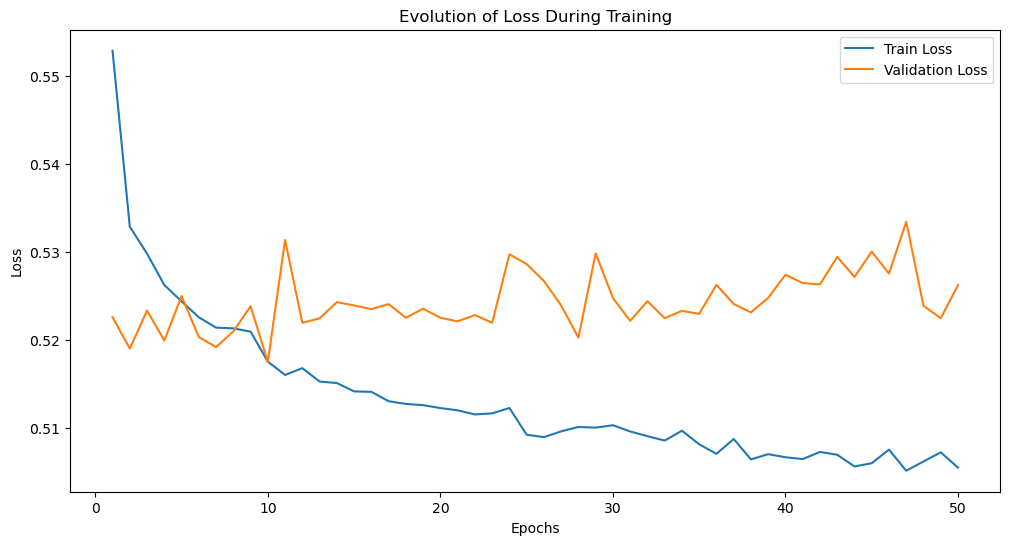

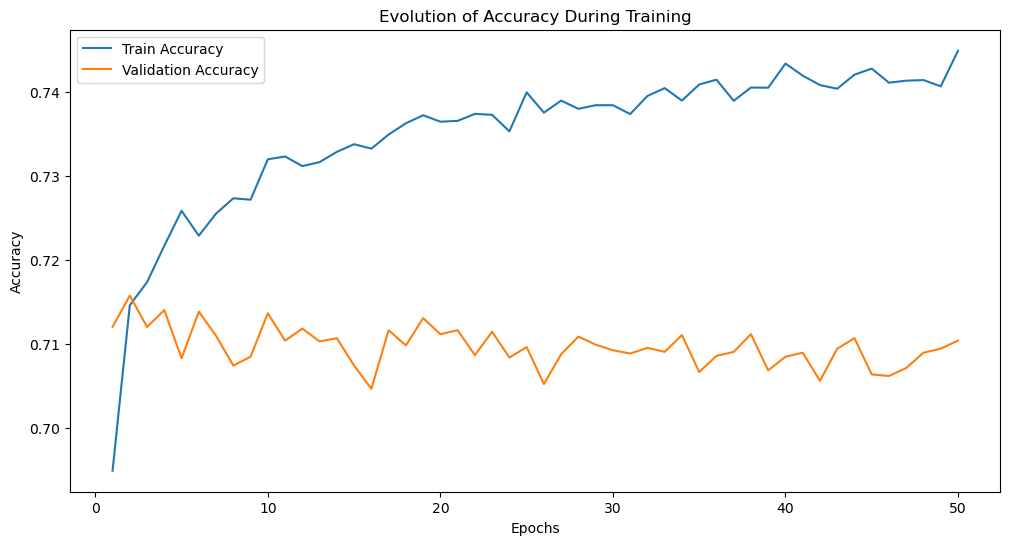

In [39]:
import matplotlib.pyplot as plt

# Graficar la pérdida
plt.figure(figsize=(12, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Evolution of Loss During Training')
plt.legend()
plt.show()

# Graficar la precisión
plt.figure(figsize=(12, 6))
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Evolution of Accuracy During Training')
plt.legend()
plt.show()
